# Convolutional Auto-encoder

![](https://cdn-images-1.medium.com/max/800/1*LSYNW5m3TN7xRX61BZhoZA.png)

In this example we will demonstrate how you can create a convolutionnal auto-encoder in Gluon

In [243]:
import random

import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import autograd, nd, gluon

## Data

We will use the FashionMNIST dataset which is of a similar format than MNIST but is richer and has more variance

In [315]:
batch_size = 512
ctx = mx.gpu() if len(mx.test_utils.list_gpus()) > 0 else mx.cpu()

In [316]:
transform = lambda x,y: (x.transpose((2,0,1)).astype('float32')/255., y)

train_dataset = gluon.data.vision.FashionMNIST(train=True)
test_dataset = gluon.data.vision.FashionMNIST(train=False)

train_dataset_t = train_dataset.transform(transform)
test_dataset_t = test_dataset.transform(transform)

train_data = gluon.data.DataLoader(train_dataset_t, batch_size=batch_size, last_batch='rollover', shuffle=True, num_workers=5)
test_data = gluon.data.DataLoader(test_dataset_t, batch_size=batch_size, last_batch='rollover', shuffle=True, num_workers=5)

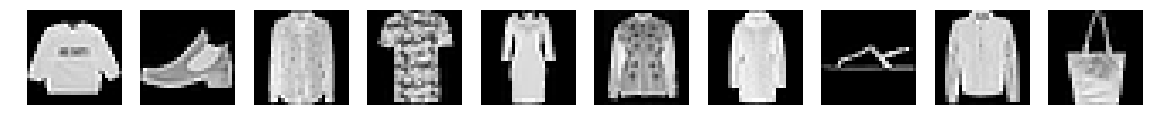

In [317]:
plt.figure(figsize=(20,10))
for i in range(10):
    ax = plt.subplot(1, 10, i+1)
    ax.imshow(train_dataset[i][0].squeeze().asnumpy(), cmap='gray')
    ax.axis('off')

## Network

In [640]:
net = gluon.nn.HybridSequential()
with net.name_scope():
    # Encoder 1x28x28 -> 32x1x1
    net.add(
        gluon.nn.Conv2D(channels=4, kernel_size=3, padding=1, strides=(2,2), activation='relu'),
        gluon.nn.BatchNorm(),
        gluon.nn.Conv2D(channels=8, kernel_size=3, padding=1, strides=(2,2), activation='relu'),
        gluon.nn.BatchNorm(),
        gluon.nn.Conv2D(channels=16, kernel_size=3, padding=1, strides=(2,2), activation='relu'),
        gluon.nn.BatchNorm(),
        gluon.nn.Conv2D(channels=32, kernel_size=3, padding=0, strides=(2,2),activation='relu'),
        gluon.nn.BatchNorm()
    )
    # Decoder 32x1x1 -> 1x28x28
    net.add(
        gluon.nn.Conv2D(channels=32, kernel_size=3, padding=2, activation='relu'),
        gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')),
        gluon.nn.BatchNorm(),
        gluon.nn.Conv2D(channels=16, kernel_size=3, padding=1, activation='relu'),
        gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')),
        gluon.nn.BatchNorm(),
        gluon.nn.Conv2D(channels=8, kernel_size=3, padding=2, activation='relu'),
        gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')),
        gluon.nn.BatchNorm(),
        gluon.nn.Conv2D(channels=4, kernel_size=3, padding=1, activation='relu'),
        gluon.nn.Conv2D(channels=1, kernel_size=3, padding=1, activation='sigmoid')
    )
    

In [641]:
net.initialize(ctx=ctx)

In [642]:
net.summary(dataset_transformed[0][0].expand_dims(axis=0).as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 1, 28, 28)               0
        Activation-1  <Symbol hybridsequential80_conv0_relu_fwd>               0
        Activation-2                              (1, 4, 14, 14)               0
            Conv2D-3                              (1, 4, 14, 14)              40
         BatchNorm-4                              (1, 4, 14, 14)              16
        Activation-5  <Symbol hybridsequential80_conv1_relu_fwd>               0
        Activation-6                                (1, 8, 7, 7)               0
            Conv2D-7                                (1, 8, 7, 7)             296
         BatchNorm-8                                (1, 8, 7, 7)              32
        Activation-9  <Symbol hybridsequential80_conv2_relu_fwd>               0
       Activation-10        

We can see that the original image goes from 28x28 = 784 pixels to a vector of length 32. That is a ~25x information compression rate.
Then the decoder brings back this compressed information to the original shape

In [643]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.001, 'wd':0.001})
net.hybridize(static_shape=True, static_alloc=True)

## Training loop

In [644]:
epochs = 50
for e in range(epochs):
    curr_loss = 0.
    for i, (data, _) in enumerate(train_data):
        data = data.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            # Compute the L1 loss between the original and the generated image
            l = (output.flatten() - data.flatten()).abs().sum(axis=1)
        l.backward()
        trainer.step(data.shape[0])
        
        curr_loss += l.mean()

    print("Epoch [{}], Loss {}".format(e, curr_loss.asscalar()/(i+1)))

Epoch [0], Loss 150.58451856303418
Epoch [1], Loss 65.12515858707265
Epoch [2], Loss 59.445904230667374
Epoch [3], Loss 56.62768763354701
Epoch [4], Loss 54.96188484909188
Epoch [5], Loss 53.87394831730769
Epoch [6], Loss 52.72701322115385
Epoch [7], Loss 51.91863496424788
Epoch [8], Loss 51.15499382345085
Epoch [9], Loss 50.44610543536325
Epoch [10], Loss 49.78377904647436
Epoch [11], Loss 49.42993790064103
Epoch [12], Loss 48.85279147907839
Epoch [13], Loss 48.56229133279915
Epoch [14], Loss 48.0335202991453
Epoch [15], Loss 47.71448484241453
Epoch [16], Loss 47.63018746661325
Epoch [17], Loss 46.98289346287393
Epoch [18], Loss 46.91378939353814
Epoch [19], Loss 46.51542467948718
Epoch [20], Loss 46.18931540464744
Epoch [21], Loss 45.93053886217949
Epoch [22], Loss 45.839977297008545
Epoch [23], Loss 45.72159278998941
Epoch [24], Loss 45.57212373130342
Epoch [25], Loss 45.30989165998932
Epoch [26], Loss 45.123990050747864
Epoch [27], Loss 45.19418569711539
Epoch [28], Loss 44.8327264

## Testing reconstruction

We plot 10 images and their reconstruction by the auto-encoder. The results are pretty good for a ~25x compression rate!

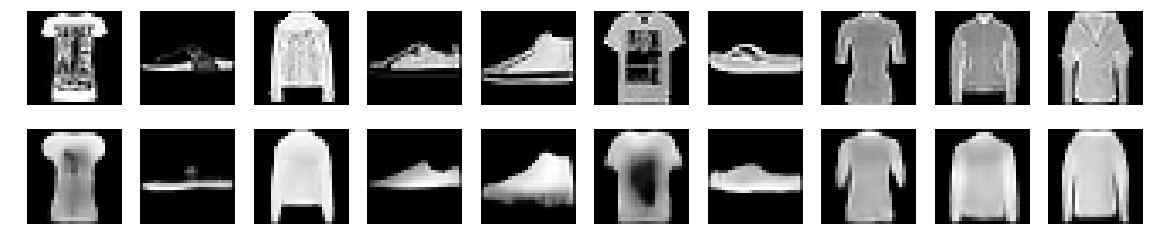

In [645]:
plt.figure(figsize=(20,4))
for i in range(10):
    idx = random.randint(0, len(test_dataset))
    img, _ = test_dataset[idx]
    x, _ = test_dataset_t[idx]

    data = x.as_in_context(ctx).expand_dims(axis=0)
    output = net(data)
    
    ax = plt.subplot(2, 10, i+1)
    ax.imshow(img.squeeze().asnumpy(), cmap='gray')
    ax.axis('off')
    ax = plt.subplot(2, 10, 10+i+1)
    ax.imshow((output[0].asnumpy() * 255.).transpose((1,2,0)).squeeze(), cmap='gray')
    _ = ax.axis('off')

## Manipulating latent space

In [646]:
net

HybridSequential(
  (0): Conv2D(1 -> 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=4)
  (2): Conv2D(4 -> 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=8)
  (4): Conv2D(8 -> 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=16)
  (6): Conv2D(16 -> 32, kernel_size=(3, 3), stride=(2, 2))
  (7): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
  (8): Conv2D(32 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (9): HybridLambda(<lambda>)
  (10): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
  (11): Conv2D(32 -> 16, kernel_size=(3, 3), stride=(1, 1), padd

We split the Autoencoder into **encoder** and **decoder** subnetworks.

In [647]:
encoder = net[:9]
decoder = net[9:]

We get two images from the testing set

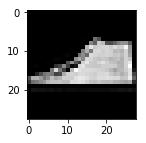

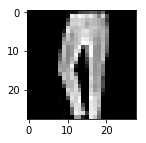

In [666]:
idx = random.randint(0, len(test_dataset))
img1, _ = test_dataset[idx]
x, _ = test_dataset_t[idx]
data1 = x.as_in_context(ctx).expand_dims(axis=0)

idx = random.randint(0, len(test_dataset))
img2, _ = test_dataset[idx]
x, _ = test_dataset_t[idx]
data2 = x.as_in_context(ctx).expand_dims(axis=0)

plt.figure(figsize=(2,2))
plt.imshow(img1.squeeze().asnumpy(), cmap='gray')
plt.show()
plt.figure(figsize=(2,2))
plt.imshow(img2.squeeze().asnumpy(), cmap='gray')

We get the latent representations of the images by passing them through the network

In [667]:
latent1 = encoder(data1)
latent2 = encoder(data2)

In [668]:
latent1.shape

(1, 32, 3, 3)

We interpolate the two latent representations, vectors of 32 values, to get a new intermediate latent representation, and plot the resulting decoded image

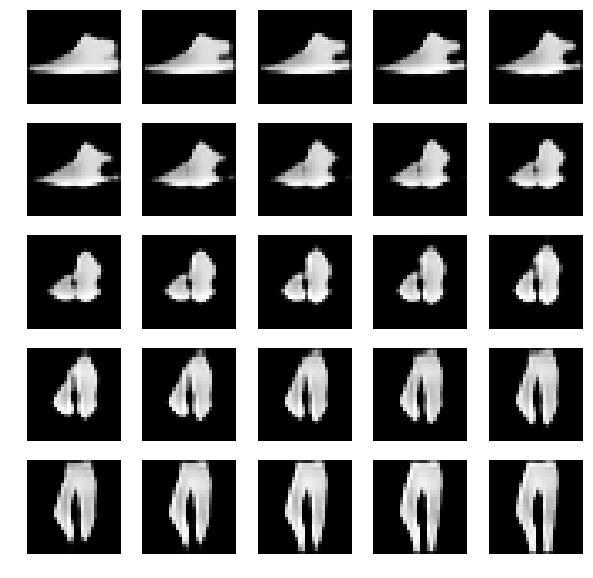

In [669]:
num = 25.
square = 5
plt.figure(figsize=(square*2, square*2))

for i in range(int(num)):
    
        new_latent = latent2*(i+1)/num + latent1*(num-i)/num
        output = decoder(new_latent)
        
        #plot result
        ax = plt.subplot(square, square, i%square+1+(i//square)*square)
        ax.imshow((output[0].asnumpy() * 255.).transpose((1,2,0)).squeeze(), cmap='gray')
        _ = ax.axis('off')

We can see taht the latent space learnt by the auto-encoder is fairly smooth, there is no sudden jump from one shape to another